In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd
import configs

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
def format_model_name(key):
    if key == 'rnn':
        return 'RNN-SF'
    elif key == 'rnn_oja':
        return 'RNN-Oja'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

In [3]:
def get_sparsity(key):
    p = re.compile('.*sparsity(.+?)\/.*')
    if 'sparsity' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

def get_sigma(key):
    p = re.compile('.*sigma(.+?)\/.*')
    if 'sigma' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

In [4]:
hue_order = [
    #'Linear',
    'RNN-SF',
    'MLP with Replay Buffer',
    #'RNN-Oja',
    #'Linear'
    #'RNN with Fixed LR', 'RNN with Dynamic LR',
    ]

# Collect aggregate metrics

In [6]:
# Collect measures of all iterations
root_dir = "/home/chingf/engram/Ching/03_hannah_dset/"

init_sparsities = []
final_sparsities = []
sigmas = []
gammas = []
models = []
start_losses = []
time_to_elbows = []
final_losses = []
chance_losses = []

for sparsity_dir in os.listdir(root_dir):
    if 'sparsity' not in sparsity_dir: continue
    for sigma_dir in os.listdir(f'{root_dir}{sparsity_dir}/'):
        for gamma_dir in os.listdir(f'{root_dir}{sparsity_dir}/{sigma_dir}/'):
            path = f'{root_dir}{sparsity_dir}/{sigma_dir}/{gamma_dir}/'
            print(path)
            
            # Get dataset parameters
            init_sparsity = get_sparsity(path)
            sigma = get_sigma(path)
            gamma = float(gamma_dir)
            
            # Iterate over models
            for model_dir in os.listdir(path):
                try:
                    model = format_model_name(model_dir)
                except:
                    continue
                model_path = f'{path}{model_dir}/'
                    
                # Gather metrics for each model iteration
                for iter_dir in os.listdir(model_path):
                    iter_path = model_path + iter_dir + '/'
                    if not os.path.isfile(iter_path + 'results.p'):
                        continue
                    for file in os.listdir(iter_path):
                        print(file)
                        if 'tfevents' not in file: continue
                        tfevents_file = iter_path + '/' + file
                        event_acc = EventAccumulator(tfevents_file)
                        event_acc.Reload()
                        try:
                            scalar_events = event_acc.Scalars('loss_train')
                        except:
                            continue
                        values = np.array([event.value for event in scalar_events])
                        if np.any(np.isnan(values)): continue
                        steps = np.array([event.step for event in scalar_events])
                        central_diffs = values[1:] + values[:-1] - 2*values[:-1]
                        if values[0] > values[-1]: # decreasing
                            val95 = values[0] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values <= val95)[0][0]
                        else: # increasing
                            val95 = values[-1] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values >= val95)[0][0]
                        
                        init_sparsities.append(init_sparsity)
                        results = pickle.load(open(iter_path + 'results.p', 'rb'))
                        final_sparsities.append(results['dset'].feature_maker.post_smooth_sparsity)
                        sigmas.append(sigma)
                        gammas.append(gamma)
                        models.append(model)
                        start_losses.append(values[0])
                        time_to_elbows.append(steps[time_to_95])
                        #time_to_elbows.append(steps[np.argmax(central_diffs)])
                        final_losses.append(values[-1])
                        if 'mlp' in model_dir:
                            chance_losses.append(np.nan)
                        else:
                            chance_losses.append(event_acc.Scalars('chance_loss')[-1].value)
                        break

init_sparsities = np.array(init_sparsities)
final_sparsities = np.array(final_sparsities)
sigmas = np.array(sigmas)
gammas = np.array(gammas)
models = np.array(models)
start_losses = np.array(start_losses)
time_to_elbows = np.array(time_to_elbows)
final_losses = np.array(final_losses)
chance_losses = np.array(chance_losses)

/home/chingf/engram/Ching/03_hannah_dset/sparsity0.0448421052631579/sigma1.5/0.75/
results.p
model.pt
events.out.tfevents.1644346599.mushroombody.aronov.zi.columbia.edu.38110.128
results.p
events.out.tfevents.1644346391.mushroombody.aronov.zi.columbia.edu.38110.124
results.p
model.pt
events.out.tfevents.1644346696.mushroombody.aronov.zi.columbia.edu.38110.130
events.out.tfevents.1644346446.mushroombody.aronov.zi.columbia.edu.38110.125
results.p
model.pt
events.out.tfevents.1644346549.mushroombody.aronov.zi.columbia.edu.38110.127
results.p
model.pt
events.out.tfevents.1644346648.mushroombody.aronov.zi.columbia.edu.38110.129
results.p
events.out.tfevents.1644346746.mushroombody.aronov.zi.columbia.edu.38110.131
events.out.tfevents.1644346279.mushroombody.aronov.zi.columbia.edu.38110.122
events.out.tfevents.1644346497.mushroombody.aronov.zi.columbia.edu.38110.126
results.p
model.pt
events.out.tfevents.1644346335.mushroombody.aronov.zi.columbia.edu.38110.123
events.out.tfevents.1644341141.m

events.out.tfevents.1644313195.mushroombody.aronov.zi.columbia.edu.38101.62
events.out.tfevents.1644299809.mushroombody.aronov.zi.columbia.edu.38101.57
events.out.tfevents.1644305257.mushroombody.aronov.zi.columbia.edu.38101.59
results.p
events.out.tfevents.1644310426.mushroombody.aronov.zi.columbia.edu.38101.61
results.p
events.out.tfevents.1644315989.mushroombody.aronov.zi.columbia.edu.38101.63
results.p
model.pt
events.out.tfevents.1644291588.mushroombody.aronov.zi.columbia.edu.38101.54
results.p
model.pt
events.out.tfevents.1644302543.mushroombody.aronov.zi.columbia.edu.38101.58
results.p
model.pt
events.out.tfevents.1644294315.mushroombody.aronov.zi.columbia.edu.38101.55
events.out.tfevents.1644318914.mushroombody.aronov.zi.columbia.edu.38101.74
results.p
model.pt
events.out.tfevents.1644318871.mushroombody.aronov.zi.columbia.edu.38101.70
results.p
model.pt
events.out.tfevents.1644318934.mushroombody.aronov.zi.columbia.edu.38101.76
events.out.tfevents.1644318880.mushroombody.arono

results.p
model.pt
events.out.tfevents.1644347305.mushroombody.aronov.zi.columbia.edu.38041.115
events.out.tfevents.1644347317.mushroombody.aronov.zi.columbia.edu.38041.117
results.p
model.pt
events.out.tfevents.1644347328.mushroombody.aronov.zi.columbia.edu.38041.119
results.p
model.pt
events.out.tfevents.1644347341.mushroombody.aronov.zi.columbia.edu.38041.121
results.p
model.pt
events.out.tfevents.1644347289.mushroombody.aronov.zi.columbia.edu.38041.112
results.p
model.pt
events.out.tfevents.1644347310.mushroombody.aronov.zi.columbia.edu.38041.116
results.p
events.out.tfevents.1644347294.mushroombody.aronov.zi.columbia.edu.38041.113
events.out.tfevents.1644329523.mushroombody.aronov.zi.columbia.edu.38041.94
events.out.tfevents.1644324206.mushroombody.aronov.zi.columbia.edu.38041.90
results.p
events.out.tfevents.1644332099.mushroombody.aronov.zi.columbia.edu.38041.96
results.p
events.out.tfevents.1644325508.mushroombody.aronov.zi.columbia.edu.38041.91
results.p
events.out.tfevents.16

results.p
model.pt
events.out.tfevents.1644327670.mushroombody.aronov.zi.columbia.edu.38030.93
events.out.tfevents.1644330403.mushroombody.aronov.zi.columbia.edu.38030.95
results.p
events.out.tfevents.1644333043.mushroombody.aronov.zi.columbia.edu.38030.97
results.p
events.out.tfevents.1644319511.mushroombody.aronov.zi.columbia.edu.38030.88
events.out.tfevents.1644326263.mushroombody.aronov.zi.columbia.edu.38030.92
events.out.tfevents.1644322133.mushroombody.aronov.zi.columbia.edu.38030.89
/home/chingf/engram/Ching/03_hannah_dset/sparsity0.03710526315789474/sigma1.5/0.75/
results.p
events.out.tfevents.1644346171.mushroombody.aronov.zi.columbia.edu.38039.128
results.p
model.pt
events.out.tfevents.1644345974.mushroombody.aronov.zi.columbia.edu.38039.124
events.out.tfevents.1644346270.mushroombody.aronov.zi.columbia.edu.38039.130
events.out.tfevents.1644346025.mushroombody.aronov.zi.columbia.edu.38039.125
results.p
events.out.tfevents.1644346124.mushroombody.aronov.zi.columbia.edu.38039.1

events.out.tfevents.1644346937.mushroombody.aronov.zi.columbia.edu.38064.127
results.p
model.pt
events.out.tfevents.1644347044.mushroombody.aronov.zi.columbia.edu.38064.129
results.p
events.out.tfevents.1644347144.mushroombody.aronov.zi.columbia.edu.38064.131
results.p
model.pt
events.out.tfevents.1644346657.mushroombody.aronov.zi.columbia.edu.38064.122
results.p
model.pt
events.out.tfevents.1644346884.mushroombody.aronov.zi.columbia.edu.38064.126
events.out.tfevents.1644346716.mushroombody.aronov.zi.columbia.edu.38064.123
events.out.tfevents.1644341425.mushroombody.aronov.zi.columbia.edu.38064.104
results.p
model.pt
events.out.tfevents.1644336374.mushroombody.aronov.zi.columbia.edu.38064.100
results.p
model.pt
events.out.tfevents.1644343971.mushroombody.aronov.zi.columbia.edu.38064.106
results.p
model.pt
events.out.tfevents.1644337640.mushroombody.aronov.zi.columbia.edu.38064.101
results.p
model.pt
events.out.tfevents.1644340162.mushroombody.aronov.zi.columbia.edu.38064.103
events.out

events.out.tfevents.1644343154.mushroombody.aronov.zi.columbia.edu.38063.105
results.p
events.out.tfevents.1644345727.mushroombody.aronov.zi.columbia.edu.38063.107
events.out.tfevents.1644334191.mushroombody.aronov.zi.columbia.edu.38063.98
results.p
model.pt
events.out.tfevents.1644339303.mushroombody.aronov.zi.columbia.edu.38063.102
results.p
model.pt
events.out.tfevents.1644335482.mushroombody.aronov.zi.columbia.edu.38063.99
results.p
events.out.tfevents.1644347083.mushroombody.aronov.zi.columbia.edu.38063.118
results.p
model.pt
events.out.tfevents.1644347059.mushroombody.aronov.zi.columbia.edu.38063.114
results.p
model.pt
events.out.tfevents.1644347093.mushroombody.aronov.zi.columbia.edu.38063.120
results.p
model.pt
events.out.tfevents.1644347066.mushroombody.aronov.zi.columbia.edu.38063.115
results.p
model.pt
events.out.tfevents.1644347077.mushroombody.aronov.zi.columbia.edu.38063.117
events.out.tfevents.1644347087.mushroombody.aronov.zi.columbia.edu.38063.119
results.p
events.out.

results.p
model.pt
events.out.tfevents.1644264096.mushroombody.aronov.zi.columbia.edu.38060.31
results.p
events.out.tfevents.1644264119.mushroombody.aronov.zi.columbia.edu.38060.33
events.out.tfevents.1644263980.mushroombody.aronov.zi.columbia.edu.38060.24
events.out.tfevents.1644264055.mushroombody.aronov.zi.columbia.edu.38060.28
events.out.tfevents.1644263995.mushroombody.aronov.zi.columbia.edu.38060.25
results.p
model.pt
events.out.tfevents.1644223051.mushroombody.aronov.zi.columbia.edu.38060.6
events.out.tfevents.1644212021.mushroombody.aronov.zi.columbia.edu.38060.2
events.out.tfevents.1644228635.mushroombody.aronov.zi.columbia.edu.38060.8
results.p
model.pt
events.out.tfevents.1644214781.mushroombody.aronov.zi.columbia.edu.38060.3
results.p
model.pt
events.out.tfevents.1644220289.mushroombody.aronov.zi.columbia.edu.38060.5
results.p
model.pt
events.out.tfevents.1644225842.mushroombody.aronov.zi.columbia.edu.38060.7
results.p
model.pt
events.out.tfevents.1644231601.mushroombody.ar

results.p
events.out.tfevents.1644231110.mushroombody.aronov.zi.columbia.edu.38036.9
results.p
model.pt
events.out.tfevents.1644206644.mushroombody.aronov.zi.columbia.edu.38036.0
events.out.tfevents.1644217354.mushroombody.aronov.zi.columbia.edu.38036.4
events.out.tfevents.1644209335.mushroombody.aronov.zi.columbia.edu.38036.1
/home/chingf/engram/Ching/03_hannah_dset/sparsity0.02694736842105263/sigma2.5/0.75/
results.p
model.pt
events.out.tfevents.1644347721.mushroombody.aronov.zi.columbia.edu.38106.128
results.p
model.pt
events.out.tfevents.1644347546.mushroombody.aronov.zi.columbia.edu.38106.124
results.p
model.pt
events.out.tfevents.1644347801.mushroombody.aronov.zi.columbia.edu.38106.130
results.p
model.pt
events.out.tfevents.1644347594.mushroombody.aronov.zi.columbia.edu.38106.125
results.p
events.out.tfevents.1644347679.mushroombody.aronov.zi.columbia.edu.38106.127
results.p
model.pt
events.out.tfevents.1644347760.mushroombody.aronov.zi.columbia.edu.38106.129
results.p
events.out

results.p
model.pt
events.out.tfevents.1644261666.mushroombody.aronov.zi.columbia.edu.38045.34
results.p
model.pt
events.out.tfevents.1644262042.mushroombody.aronov.zi.columbia.edu.38045.38
results.p
model.pt
events.out.tfevents.1644261748.mushroombody.aronov.zi.columbia.edu.38045.35
results.p
events.out.tfevents.1644250205.mushroombody.aronov.zi.columbia.edu.38045.16
results.p
events.out.tfevents.1644239602.mushroombody.aronov.zi.columbia.edu.38045.12
results.p
model.pt
events.out.tfevents.1644255559.mushroombody.aronov.zi.columbia.edu.38045.18
events.out.tfevents.1644242274.mushroombody.aronov.zi.columbia.edu.38045.13
results.p
model.pt
events.out.tfevents.1644247519.mushroombody.aronov.zi.columbia.edu.38045.15
results.p
model.pt
events.out.tfevents.1644252890.mushroombody.aronov.zi.columbia.edu.38045.17
results.p
model.pt
events.out.tfevents.1644258298.mushroombody.aronov.zi.columbia.edu.38045.19
results.p
model.pt
events.out.tfevents.1644233479.mushroombody.aronov.zi.columbia.edu.3

results.p
model.pt
events.out.tfevents.1644236957.mushroombody.aronov.zi.columbia.edu.38033.11
results.p
model.pt
events.out.tfevents.1644261714.mushroombody.aronov.zi.columbia.edu.38033.30
results.p
events.out.tfevents.1644261670.mushroombody.aronov.zi.columbia.edu.38033.26
results.p
model.pt
events.out.tfevents.1644261734.mushroombody.aronov.zi.columbia.edu.38033.32
results.p
model.pt
events.out.tfevents.1644261681.mushroombody.aronov.zi.columbia.edu.38033.27
results.p
events.out.tfevents.1644261704.mushroombody.aronov.zi.columbia.edu.38033.29
events.out.tfevents.1644261724.mushroombody.aronov.zi.columbia.edu.38033.31
results.p
events.out.tfevents.1644261743.mushroombody.aronov.zi.columbia.edu.38033.33
results.p
events.out.tfevents.1644261642.mushroombody.aronov.zi.columbia.edu.38033.24
events.out.tfevents.1644261691.mushroombody.aronov.zi.columbia.edu.38033.28
results.p
events.out.tfevents.1644261656.mushroombody.aronov.zi.columbia.edu.38033.25
results.p
model.pt
events.out.tfevents

results.p
events.out.tfevents.1644211932.mushroombody.aronov.zi.columbia.edu.38053.2
events.out.tfevents.1644228139.mushroombody.aronov.zi.columbia.edu.38053.8
results.p
model.pt
events.out.tfevents.1644214593.mushroombody.aronov.zi.columbia.edu.38053.3
results.p
model.pt
events.out.tfevents.1644219966.mushroombody.aronov.zi.columbia.edu.38053.5
events.out.tfevents.1644225401.mushroombody.aronov.zi.columbia.edu.38053.7
results.p
model.pt
events.out.tfevents.1644231035.mushroombody.aronov.zi.columbia.edu.38053.9
results.p
model.pt
events.out.tfevents.1644206644.mushroombody.aronov.zi.columbia.edu.38053.0
results.p
events.out.tfevents.1644217292.mushroombody.aronov.zi.columbia.edu.38053.4
results.p
model.pt
events.out.tfevents.1644209312.mushroombody.aronov.zi.columbia.edu.38053.1
/home/chingf/engram/Ching/03_hannah_dset/sparsity0.017210526315789475/sigma3.0/0.75/
events.out.tfevents.1644319816.mushroombody.aronov.zi.columbia.edu.38054.84
results.p
events.out.tfevents.1644319445.mushroom

results.p
model.pt
events.out.tfevents.1644347321.mushroombody.aronov.zi.columbia.edu.38057.125
events.out.tfevents.1644347416.mushroombody.aronov.zi.columbia.edu.38057.127
results.p
model.pt
events.out.tfevents.1644347504.mushroombody.aronov.zi.columbia.edu.38057.129
results.p
events.out.tfevents.1644347594.mushroombody.aronov.zi.columbia.edu.38057.131
results.p
model.pt
events.out.tfevents.1644347152.mushroombody.aronov.zi.columbia.edu.38057.122
results.p
model.pt
events.out.tfevents.1644347371.mushroombody.aronov.zi.columbia.edu.38057.126
results.p
events.out.tfevents.1644347212.mushroombody.aronov.zi.columbia.edu.38057.123
results.p
model.pt
events.out.tfevents.1644341961.mushroombody.aronov.zi.columbia.edu.38057.104
results.p
events.out.tfevents.1644336772.mushroombody.aronov.zi.columbia.edu.38057.100
results.p
events.out.tfevents.1644344547.mushroombody.aronov.zi.columbia.edu.38057.106
results.p
events.out.tfevents.1644338050.mushroombody.aronov.zi.columbia.edu.38057.101
results.

results.p
model.pt
events.out.tfevents.1644340127.mushroombody.aronov.zi.columbia.edu.38033.103
results.p
model.pt
events.out.tfevents.1644342679.mushroombody.aronov.zi.columbia.edu.38033.105
results.p
model.pt
events.out.tfevents.1644345221.mushroombody.aronov.zi.columbia.edu.38033.107
results.p
events.out.tfevents.1644333832.mushroombody.aronov.zi.columbia.edu.38033.98
results.p
model.pt
events.out.tfevents.1644338866.mushroombody.aronov.zi.columbia.edu.38033.102
results.p
model.pt
events.out.tfevents.1644335115.mushroombody.aronov.zi.columbia.edu.38033.99
results.p
model.pt
events.out.tfevents.1644346605.mushroombody.aronov.zi.columbia.edu.38033.118
results.p
events.out.tfevents.1644346583.mushroombody.aronov.zi.columbia.edu.38033.114
results.p
events.out.tfevents.1644346618.mushroombody.aronov.zi.columbia.edu.38033.120
events.out.tfevents.1644346589.mushroombody.aronov.zi.columbia.edu.38033.115
events.out.tfevents.1644346599.mushroombody.aronov.zi.columbia.edu.38033.117
results.p
m

events.out.tfevents.1644320401.mushroombody.aronov.zi.columbia.edu.38086.75
events.out.tfevents.1644320422.mushroombody.aronov.zi.columbia.edu.38086.77
results.p
model.pt
events.out.tfevents.1644320335.mushroombody.aronov.zi.columbia.edu.38086.68
results.p
model.pt
events.out.tfevents.1644320374.mushroombody.aronov.zi.columbia.edu.38086.72
results.p
model.pt
events.out.tfevents.1644320345.mushroombody.aronov.zi.columbia.edu.38086.69
results.p
model.pt
events.out.tfevents.1644281583.mushroombody.aronov.zi.columbia.edu.38086.50
results.p
model.pt
events.out.tfevents.1644270418.mushroombody.aronov.zi.columbia.edu.38086.46
events.out.tfevents.1644287090.mushroombody.aronov.zi.columbia.edu.38086.52
results.p
model.pt
events.out.tfevents.1644273102.mushroombody.aronov.zi.columbia.edu.38086.47
results.p
model.pt
events.out.tfevents.1644278836.mushroombody.aronov.zi.columbia.edu.38086.49
events.out.tfevents.1644284354.mushroombody.aronov.zi.columbia.edu.38086.51
results.p
events.out.tfevents.1

results.p
events.out.tfevents.1644263449.mushroombody.aronov.zi.columbia.edu.38030.44
events.out.tfevents.1644274812.mushroombody.aronov.zi.columbia.edu.38030.48
results.p
model.pt
events.out.tfevents.1644266656.mushroombody.aronov.zi.columbia.edu.38030.45
/home/chingf/engram/Ching/03_hannah_dset/sparsity0.008736842105263157/sigma1.5/0.75/
events.out.tfevents.1644321869.mushroombody.aronov.zi.columbia.edu.38104.84
events.out.tfevents.1644321554.mushroombody.aronov.zi.columbia.edu.38104.80
events.out.tfevents.1644322019.mushroombody.aronov.zi.columbia.edu.38104.86
results.p
model.pt
events.out.tfevents.1644321642.mushroombody.aronov.zi.columbia.edu.38104.81
results.p
model.pt
events.out.tfevents.1644321801.mushroombody.aronov.zi.columbia.edu.38104.83
results.p
model.pt
events.out.tfevents.1644321937.mushroombody.aronov.zi.columbia.edu.38104.85
results.p
model.pt
events.out.tfevents.1644322096.mushroombody.aronov.zi.columbia.edu.38104.87
results.p
model.pt
events.out.tfevents.1644321376.

results.p
model.pt
events.out.tfevents.1644264090.mushroombody.aronov.zi.columbia.edu.38049.43
events.out.tfevents.1644262649.mushroombody.aronov.zi.columbia.edu.38049.34
results.p
model.pt
events.out.tfevents.1644263232.mushroombody.aronov.zi.columbia.edu.38049.38
results.p
events.out.tfevents.1644262758.mushroombody.aronov.zi.columbia.edu.38049.35
results.p
events.out.tfevents.1644250806.mushroombody.aronov.zi.columbia.edu.38049.16
results.p
model.pt
events.out.tfevents.1644240044.mushroombody.aronov.zi.columbia.edu.38049.12
events.out.tfevents.1644256182.mushroombody.aronov.zi.columbia.edu.38049.18
results.p
model.pt
events.out.tfevents.1644242733.mushroombody.aronov.zi.columbia.edu.38049.13
results.p
model.pt
events.out.tfevents.1644248111.mushroombody.aronov.zi.columbia.edu.38049.15
events.out.tfevents.1644253505.mushroombody.aronov.zi.columbia.edu.38049.17
results.p
model.pt
events.out.tfevents.1644258886.mushroombody.aronov.zi.columbia.edu.38049.19
results.p
model.pt
events.out.

results.p
model.pt
events.out.tfevents.1644344238.mushroombody.aronov.zi.columbia.edu.38053.107
events.out.tfevents.1644333170.mushroombody.aronov.zi.columbia.edu.38053.98
results.p
model.pt
events.out.tfevents.1644338085.mushroombody.aronov.zi.columbia.edu.38053.102
results.p
events.out.tfevents.1644334437.mushroombody.aronov.zi.columbia.edu.38053.99
events.out.tfevents.1644345524.mushroombody.aronov.zi.columbia.edu.38053.118
results.p
model.pt
field_infos.p
events.out.tfevents.1644345493.mushroombody.aronov.zi.columbia.edu.38053.114
results.p
events.out.tfevents.1644345539.mushroombody.aronov.zi.columbia.edu.38053.120
events.out.tfevents.1644345500.mushroombody.aronov.zi.columbia.edu.38053.115
results.p
model.pt
events.out.tfevents.1644345512.mushroombody.aronov.zi.columbia.edu.38053.117
events.out.tfevents.1644345531.mushroombody.aronov.zi.columbia.edu.38053.119
results.p
model.pt
events.out.tfevents.1644345545.mushroombody.aronov.zi.columbia.edu.38053.121
results.p
events.out.tfeve

results.p
model.pt
events.out.tfevents.1644263658.mushroombody.aronov.zi.columbia.edu.38097.28
events.out.tfevents.1644263595.mushroombody.aronov.zi.columbia.edu.38097.25
results.p
events.out.tfevents.1644223006.mushroombody.aronov.zi.columbia.edu.38097.6
results.p
events.out.tfevents.1644212054.mushroombody.aronov.zi.columbia.edu.38097.2
results.p
model.pt
events.out.tfevents.1644228595.mushroombody.aronov.zi.columbia.edu.38097.8
events.out.tfevents.1644214775.mushroombody.aronov.zi.columbia.edu.38097.3
results.p
events.out.tfevents.1644220283.mushroombody.aronov.zi.columbia.edu.38097.5
results.p
events.out.tfevents.1644225801.mushroombody.aronov.zi.columbia.edu.38097.7
results.p
model.pt
events.out.tfevents.1644231551.mushroombody.aronov.zi.columbia.edu.38097.9
events.out.tfevents.1644206646.mushroombody.aronov.zi.columbia.edu.38097.0
results.p
model.pt
events.out.tfevents.1644217516.mushroombody.aronov.zi.columbia.edu.38097.4
results.p
model.pt
events.out.tfevents.1644209372.mushroo

/home/chingf/engram/Ching/03_hannah_dset/sparsity0.0033157894736842103/sigma3.0/0.75/
results.p
model.pt
events.out.tfevents.1644319815.mushroombody.aronov.zi.columbia.edu.38035.84
results.p
events.out.tfevents.1644319445.mushroombody.aronov.zi.columbia.edu.38035.80
results.p
model.pt
events.out.tfevents.1644319989.mushroombody.aronov.zi.columbia.edu.38035.86
results.p
model.pt
events.out.tfevents.1644319537.mushroombody.aronov.zi.columbia.edu.38035.81
results.p
model.pt
events.out.tfevents.1644319726.mushroombody.aronov.zi.columbia.edu.38035.83
results.p
model.pt
events.out.tfevents.1644319902.mushroombody.aronov.zi.columbia.edu.38035.85
events.out.tfevents.1644320073.mushroombody.aronov.zi.columbia.edu.38035.87
events.out.tfevents.1644319264.mushroombody.aronov.zi.columbia.edu.38035.78
results.p
events.out.tfevents.1644319632.mushroombody.aronov.zi.columbia.edu.38035.82
results.p
model.pt
events.out.tfevents.1644319352.mushroombody.aronov.zi.columbia.edu.38035.79
results.p
model.pt
e

results.p
model.pt
events.out.tfevents.1644250511.mushroombody.aronov.zi.columbia.edu.38078.16
events.out.tfevents.1644239836.mushroombody.aronov.zi.columbia.edu.38078.12
events.out.tfevents.1644255835.mushroombody.aronov.zi.columbia.edu.38078.18
results.p
model.pt
events.out.tfevents.1644242518.mushroombody.aronov.zi.columbia.edu.38078.13
results.p
model.pt
events.out.tfevents.1644247834.mushroombody.aronov.zi.columbia.edu.38078.15
results.p
model.pt
events.out.tfevents.1644253183.mushroombody.aronov.zi.columbia.edu.38078.17
results.p
model.pt
events.out.tfevents.1644258510.mushroombody.aronov.zi.columbia.edu.38078.19
results.p
model.pt
events.out.tfevents.1644233848.mushroombody.aronov.zi.columbia.edu.38078.10
results.p
model.pt
events.out.tfevents.1644245210.mushroombody.aronov.zi.columbia.edu.38078.14
events.out.tfevents.1644237043.mushroombody.aronov.zi.columbia.edu.38078.11
results.p
model.pt
field_infos.p
events.out.tfevents.1644261844.mushroombody.aronov.zi.columbia.edu.38078.3

results.p
events.out.tfevents.1644320676.mushroombody.aronov.zi.columbia.edu.38089.70
events.out.tfevents.1644320744.mushroombody.aronov.zi.columbia.edu.38089.76
events.out.tfevents.1644320685.mushroombody.aronov.zi.columbia.edu.38089.71
results.p
events.out.tfevents.1644320706.mushroombody.aronov.zi.columbia.edu.38089.73
results.p
model.pt
events.out.tfevents.1644320733.mushroombody.aronov.zi.columbia.edu.38089.75
events.out.tfevents.1644320754.mushroombody.aronov.zi.columbia.edu.38089.77
results.p
model.pt
events.out.tfevents.1644320657.mushroombody.aronov.zi.columbia.edu.38089.68
results.p
model.pt
events.out.tfevents.1644320694.mushroombody.aronov.zi.columbia.edu.38089.72
results.p
events.out.tfevents.1644320667.mushroombody.aronov.zi.columbia.edu.38089.69
results.p
events.out.tfevents.1644281371.mushroombody.aronov.zi.columbia.edu.38089.50
results.p
model.pt
events.out.tfevents.1644269947.mushroombody.aronov.zi.columbia.edu.38089.46
events.out.tfevents.1644286951.mushroombody.aron

events.out.tfevents.1644274103.mushroombody.aronov.zi.columbia.edu.38043.47
events.out.tfevents.1644279930.mushroombody.aronov.zi.columbia.edu.38043.49
results.p
model.pt
events.out.tfevents.1644285553.mushroombody.aronov.zi.columbia.edu.38043.51
events.out.tfevents.1644291152.mushroombody.aronov.zi.columbia.edu.38043.53
results.p
model.pt
events.out.tfevents.1644265580.mushroombody.aronov.zi.columbia.edu.38043.44
events.out.tfevents.1644276869.mushroombody.aronov.zi.columbia.edu.38043.48
results.p
events.out.tfevents.1644268429.mushroombody.aronov.zi.columbia.edu.38043.45
/home/chingf/engram/Ching/03_hannah_dset/sparsity0.017789473684210525/sigma2.5/0.75/
results.p
events.out.tfevents.1644349483.mushroombody.aronov.zi.columbia.edu.38065.128
results.p
model.pt
events.out.tfevents.1644349308.mushroombody.aronov.zi.columbia.edu.38065.124
results.p
events.out.tfevents.1644349565.mushroombody.aronov.zi.columbia.edu.38065.130
results.p
model.pt
events.out.tfevents.1644349353.mushroombody.ar

events.out.tfevents.1644321307.mushroombody.aronov.zi.columbia.edu.38069.80
results.p
model.pt
events.out.tfevents.1644321821.mushroombody.aronov.zi.columbia.edu.38069.86
results.p
model.pt
events.out.tfevents.1644321395.mushroombody.aronov.zi.columbia.edu.38069.81
events.out.tfevents.1644321572.mushroombody.aronov.zi.columbia.edu.38069.83
results.p
model.pt
events.out.tfevents.1644321740.mushroombody.aronov.zi.columbia.edu.38069.85
results.p
model.pt
events.out.tfevents.1644321896.mushroombody.aronov.zi.columbia.edu.38069.87
results.p
events.out.tfevents.1644321130.mushroombody.aronov.zi.columbia.edu.38069.78
events.out.tfevents.1644321484.mushroombody.aronov.zi.columbia.edu.38069.82
results.p
events.out.tfevents.1644321217.mushroombody.aronov.zi.columbia.edu.38069.79
results.p
model.pt
events.out.tfevents.1644309757.mushroombody.aronov.zi.columbia.edu.38069.60
results.p
model.pt
events.out.tfevents.1644298697.mushroombody.aronov.zi.columbia.edu.38069.56
events.out.tfevents.1644315369

results.p
events.out.tfevents.1644257046.mushroombody.aronov.zi.columbia.edu.38079.18
events.out.tfevents.1644243310.mushroombody.aronov.zi.columbia.edu.38079.13
results.p
events.out.tfevents.1644248813.mushroombody.aronov.zi.columbia.edu.38079.15
results.p
events.out.tfevents.1644254280.mushroombody.aronov.zi.columbia.edu.38079.17
results.p
events.out.tfevents.1644259803.mushroombody.aronov.zi.columbia.edu.38079.19
results.p
model.pt
events.out.tfevents.1644234720.mushroombody.aronov.zi.columbia.edu.38079.10
results.p
events.out.tfevents.1644246096.mushroombody.aronov.zi.columbia.edu.38079.14
results.p
model.pt
events.out.tfevents.1644237861.mushroombody.aronov.zi.columbia.edu.38079.11
results.p
events.out.tfevents.1644264013.mushroombody.aronov.zi.columbia.edu.38079.30
results.p
model.pt
field_infos.p
events.out.tfevents.1644263950.mushroombody.aronov.zi.columbia.edu.38079.26
results.p
model.pt
field_infos.p
events.out.tfevents.1644264058.mushroombody.aronov.zi.columbia.edu.38079.32


results.p
events.out.tfevents.1644261334.mushroombody.aronov.zi.columbia.edu.38052.32
results.p
events.out.tfevents.1644261259.mushroombody.aronov.zi.columbia.edu.38052.27
results.p
events.out.tfevents.1644261304.mushroombody.aronov.zi.columbia.edu.38052.29
results.p
events.out.tfevents.1644261324.mushroombody.aronov.zi.columbia.edu.38052.31
results.p
events.out.tfevents.1644261343.mushroombody.aronov.zi.columbia.edu.38052.33
results.p
model.pt
events.out.tfevents.1644261202.mushroombody.aronov.zi.columbia.edu.38052.24
results.p
events.out.tfevents.1644261283.mushroombody.aronov.zi.columbia.edu.38052.28
results.p
events.out.tfevents.1644261220.mushroombody.aronov.zi.columbia.edu.38052.25
results.p
model.pt
events.out.tfevents.1644222600.mushroombody.aronov.zi.columbia.edu.38052.6
events.out.tfevents.1644211914.mushroombody.aronov.zi.columbia.edu.38052.2
results.p
events.out.tfevents.1644228037.mushroombody.aronov.zi.columbia.edu.38052.8
results.p
model.pt
events.out.tfevents.1644214589

events.out.tfevents.1644324962.mushroombody.aronov.zi.columbia.edu.38035.91
results.p
model.pt
events.out.tfevents.1644327480.mushroombody.aronov.zi.columbia.edu.38035.93
events.out.tfevents.1644330051.mushroombody.aronov.zi.columbia.edu.38035.95
events.out.tfevents.1644332651.mushroombody.aronov.zi.columbia.edu.38035.97
results.p
events.out.tfevents.1644320175.mushroombody.aronov.zi.columbia.edu.38035.88
results.p
events.out.tfevents.1644326227.mushroombody.aronov.zi.columbia.edu.38035.92
results.p
model.pt
events.out.tfevents.1644322369.mushroombody.aronov.zi.columbia.edu.38035.89
/home/chingf/engram/Ching/03_hannah_dset/sparsity0.035894736842105264/sigma2.0/0.75/
results.p
model.pt
events.out.tfevents.1644317738.mushroombody.aronov.zi.columbia.edu.38029.84
events.out.tfevents.1644317419.mushroombody.aronov.zi.columbia.edu.38029.80
results.p
events.out.tfevents.1644317904.mushroombody.aronov.zi.columbia.edu.38029.86
events.out.tfevents.1644317499.mushroombody.aronov.zi.columbia.edu.3

results.p
events.out.tfevents.1644319565.mushroombody.aronov.zi.columbia.edu.38098.85
results.p
events.out.tfevents.1644319750.mushroombody.aronov.zi.columbia.edu.38098.87
results.p
model.pt
events.out.tfevents.1644318938.mushroombody.aronov.zi.columbia.edu.38098.78
results.p
events.out.tfevents.1644319299.mushroombody.aronov.zi.columbia.edu.38098.82
results.p
model.pt
events.out.tfevents.1644319031.mushroombody.aronov.zi.columbia.edu.38098.79
events.out.tfevents.1644307678.mushroombody.aronov.zi.columbia.edu.38098.60
results.p
model.pt
events.out.tfevents.1644297031.mushroombody.aronov.zi.columbia.edu.38098.56
events.out.tfevents.1644313194.mushroombody.aronov.zi.columbia.edu.38098.62
results.p
model.pt
events.out.tfevents.1644299455.mushroombody.aronov.zi.columbia.edu.38098.57
results.p
model.pt
events.out.tfevents.1644304933.mushroombody.aronov.zi.columbia.edu.38098.59
events.out.tfevents.1644310426.mushroombody.aronov.zi.columbia.edu.38098.61
results.p
model.pt
events.out.tfevents.

results.p
model.pt
events.out.tfevents.1644246630.mushroombody.aronov.zi.columbia.edu.38043.14
results.p
events.out.tfevents.1644238254.mushroombody.aronov.zi.columbia.edu.38043.11
results.p
model.pt
events.out.tfevents.1644264609.mushroombody.aronov.zi.columbia.edu.38043.30
results.p
model.pt
events.out.tfevents.1644264561.mushroombody.aronov.zi.columbia.edu.38043.26
results.p
model.pt
events.out.tfevents.1644264630.mushroombody.aronov.zi.columbia.edu.38043.32
results.p
events.out.tfevents.1644264577.mushroombody.aronov.zi.columbia.edu.38043.27
results.p
model.pt
events.out.tfevents.1644264599.mushroombody.aronov.zi.columbia.edu.38043.29
results.p
model.pt
events.out.tfevents.1644264620.mushroombody.aronov.zi.columbia.edu.38043.31
results.p
events.out.tfevents.1644264641.mushroombody.aronov.zi.columbia.edu.38043.33
results.p
events.out.tfevents.1644264539.mushroombody.aronov.zi.columbia.edu.38043.24
results.p
model.pt
events.out.tfevents.1644264588.mushroombody.aronov.zi.columbia.edu.

results.p
events.out.tfevents.1644280142.mushroombody.aronov.zi.columbia.edu.38110.50
results.p
model.pt
events.out.tfevents.1644268976.mushroombody.aronov.zi.columbia.edu.38110.46
results.p
events.out.tfevents.1644285581.mushroombody.aronov.zi.columbia.edu.38110.52
results.p
model.pt
events.out.tfevents.1644271780.mushroombody.aronov.zi.columbia.edu.38110.47
events.out.tfevents.1644277170.mushroombody.aronov.zi.columbia.edu.38110.49
results.p
events.out.tfevents.1644282886.mushroombody.aronov.zi.columbia.edu.38110.51
results.p
events.out.tfevents.1644288274.mushroombody.aronov.zi.columbia.edu.38110.53
results.p
model.pt
events.out.tfevents.1644263483.mushroombody.aronov.zi.columbia.edu.38110.44
events.out.tfevents.1644274455.mushroombody.aronov.zi.columbia.edu.38110.48
results.p
model.pt
events.out.tfevents.1644266638.mushroombody.aronov.zi.columbia.edu.38110.45
/home/chingf/engram/Ching/03_hannah_dset/sparsity0.001/sigma1.5/0.75/
results.p
model.pt
events.out.tfevents.1644321438.mush

results.p
model.pt
events.out.tfevents.1644263451.mushroombody.aronov.zi.columbia.edu.38047.36
results.p
model.pt
events.out.tfevents.1644264305.mushroombody.aronov.zi.columbia.edu.38047.42
results.p
model.pt
events.out.tfevents.1644263655.mushroombody.aronov.zi.columbia.edu.38047.37
events.out.tfevents.1644263961.mushroombody.aronov.zi.columbia.edu.38047.39
results.p
events.out.tfevents.1644264199.mushroombody.aronov.zi.columbia.edu.38047.41
results.p
model.pt
events.out.tfevents.1644264412.mushroombody.aronov.zi.columbia.edu.38047.43
results.p
model.pt
events.out.tfevents.1644263141.mushroombody.aronov.zi.columbia.edu.38047.34
results.p
events.out.tfevents.1644263821.mushroombody.aronov.zi.columbia.edu.38047.38
results.p
model.pt
events.out.tfevents.1644263260.mushroombody.aronov.zi.columbia.edu.38047.35
events.out.tfevents.1644251048.mushroombody.aronov.zi.columbia.edu.38047.16
results.p
model.pt
events.out.tfevents.1644240197.mushroombody.aronov.zi.columbia.edu.38047.12
results.p
m

results.p
model.pt
events.out.tfevents.1644248563.mushroombody.aronov.zi.columbia.edu.38086.15
events.out.tfevents.1644253991.mushroombody.aronov.zi.columbia.edu.38086.17
results.p
events.out.tfevents.1644259493.mushroombody.aronov.zi.columbia.edu.38086.19
results.p
model.pt
events.out.tfevents.1644234445.mushroombody.aronov.zi.columbia.edu.38086.10
events.out.tfevents.1644245852.mushroombody.aronov.zi.columbia.edu.38086.14
results.p
model.pt
events.out.tfevents.1644237557.mushroombody.aronov.zi.columbia.edu.38086.11
results.p
events.out.tfevents.1644263333.mushroombody.aronov.zi.columbia.edu.38086.30
results.p
events.out.tfevents.1644263263.mushroombody.aronov.zi.columbia.edu.38086.26
events.out.tfevents.1644263384.mushroombody.aronov.zi.columbia.edu.38086.32
results.p
model.pt
events.out.tfevents.1644263277.mushroombody.aronov.zi.columbia.edu.38086.27
events.out.tfevents.1644263312.mushroombody.aronov.zi.columbia.edu.38086.29
results.p
model.pt
events.out.tfevents.1644263358.mushroom

results.p
model.pt
events.out.tfevents.1644317666.mushroombody.aronov.zi.columbia.edu.38040.77
results.p
events.out.tfevents.1644317575.mushroombody.aronov.zi.columbia.edu.38040.68
results.p
events.out.tfevents.1644317615.mushroombody.aronov.zi.columbia.edu.38040.72
results.p
model.pt
events.out.tfevents.1644317587.mushroombody.aronov.zi.columbia.edu.38040.69
results.p
events.out.tfevents.1644279695.mushroombody.aronov.zi.columbia.edu.38040.50
events.out.tfevents.1644268636.mushroombody.aronov.zi.columbia.edu.38040.46
results.p
events.out.tfevents.1644285107.mushroombody.aronov.zi.columbia.edu.38040.52
events.out.tfevents.1644271410.mushroombody.aronov.zi.columbia.edu.38040.47
results.p
events.out.tfevents.1644276746.mushroombody.aronov.zi.columbia.edu.38040.49
results.p
model.pt
events.out.tfevents.1644282397.mushroombody.aronov.zi.columbia.edu.38040.51
results.p
model.pt
events.out.tfevents.1644287790.mushroombody.aronov.zi.columbia.edu.38040.53
results.p
model.pt
events.out.tfevents

results.p
model.pt
events.out.tfevents.1644274647.mushroombody.aronov.zi.columbia.edu.38063.48
results.p
events.out.tfevents.1644266468.mushroombody.aronov.zi.columbia.edu.38063.45
/home/chingf/engram/Ching/03_hannah_dset/sparsity0.12647368421052632/sigma0.5/0.75/
results.p
model.pt
events.out.tfevents.1644321380.mushroombody.aronov.zi.columbia.edu.38081.84
results.p
model.pt
events.out.tfevents.1644321030.mushroombody.aronov.zi.columbia.edu.38081.80
results.p
model.pt
events.out.tfevents.1644321550.mushroombody.aronov.zi.columbia.edu.38081.86
results.p
model.pt
events.out.tfevents.1644321122.mushroombody.aronov.zi.columbia.edu.38081.81
results.p
events.out.tfevents.1644321301.mushroombody.aronov.zi.columbia.edu.38081.83
results.p
events.out.tfevents.1644321466.mushroombody.aronov.zi.columbia.edu.38081.85
events.out.tfevents.1644321621.mushroombody.aronov.zi.columbia.edu.38081.87
results.p
model.pt
events.out.tfevents.1644320847.mushroombody.aronov.zi.columbia.edu.38081.78
results.p
mo

results.p
model.pt
events.out.tfevents.1644320459.mushroombody.aronov.zi.columbia.edu.38075.79
results.p
events.out.tfevents.1644308924.mushroombody.aronov.zi.columbia.edu.38075.60
events.out.tfevents.1644297817.mushroombody.aronov.zi.columbia.edu.38075.56
results.p
model.pt
events.out.tfevents.1644314564.mushroombody.aronov.zi.columbia.edu.38075.62
results.p
model.pt
events.out.tfevents.1644300615.mushroombody.aronov.zi.columbia.edu.38075.57
results.p
model.pt
events.out.tfevents.1644306127.mushroombody.aronov.zi.columbia.edu.38075.59
results.p
model.pt
events.out.tfevents.1644311728.mushroombody.aronov.zi.columbia.edu.38075.61
results.p
events.out.tfevents.1644317403.mushroombody.aronov.zi.columbia.edu.38075.63
events.out.tfevents.1644292318.mushroombody.aronov.zi.columbia.edu.38075.54
results.p
events.out.tfevents.1644303355.mushroombody.aronov.zi.columbia.edu.38075.58
results.p
model.pt
events.out.tfevents.1644295073.mushroombody.aronov.zi.columbia.edu.38075.55
results.p
model.pt
e

results.p
model.pt
events.out.tfevents.1644262703.mushroombody.aronov.zi.columbia.edu.38098.30
events.out.tfevents.1644262641.mushroombody.aronov.zi.columbia.edu.38098.26
results.p
model.pt
events.out.tfevents.1644262731.mushroombody.aronov.zi.columbia.edu.38098.32
events.out.tfevents.1644262657.mushroombody.aronov.zi.columbia.edu.38098.27
results.p
model.pt
events.out.tfevents.1644262686.mushroombody.aronov.zi.columbia.edu.38098.29
results.p
model.pt
events.out.tfevents.1644262718.mushroombody.aronov.zi.columbia.edu.38098.31
events.out.tfevents.1644262745.mushroombody.aronov.zi.columbia.edu.38098.33
results.p
events.out.tfevents.1644262609.mushroombody.aronov.zi.columbia.edu.38098.24
results.p
events.out.tfevents.1644262674.mushroombody.aronov.zi.columbia.edu.38098.28
events.out.tfevents.1644262626.mushroombody.aronov.zi.columbia.edu.38098.25
results.p
events.out.tfevents.1644222858.mushroombody.aronov.zi.columbia.edu.38098.6
results.p
events.out.tfevents.1644212002.mushroombody.arono

events.out.tfevents.1644330818.mushroombody.aronov.zi.columbia.edu.38051.96
results.p
model.pt
events.out.tfevents.1644324642.mushroombody.aronov.zi.columbia.edu.38051.91
events.out.tfevents.1644327132.mushroombody.aronov.zi.columbia.edu.38051.93
results.p
model.pt
events.out.tfevents.1644329542.mushroombody.aronov.zi.columbia.edu.38051.95
results.p
events.out.tfevents.1644332112.mushroombody.aronov.zi.columbia.edu.38051.97
results.p
events.out.tfevents.1644319482.mushroombody.aronov.zi.columbia.edu.38051.88
results.p
events.out.tfevents.1644325891.mushroombody.aronov.zi.columbia.edu.38051.92
events.out.tfevents.1644322097.mushroombody.aronov.zi.columbia.edu.38051.89
/home/chingf/engram/Ching/03_hannah_dset/sparsity0.10573684210526316/sigma0.0/0.75/
results.p
events.out.tfevents.1644263228.mushroombody.aronov.zi.columbia.edu.38046.40
results.p
model.pt
events.out.tfevents.1644262677.mushroombody.aronov.zi.columbia.edu.38046.36
events.out.tfevents.1644263594.mushroombody.aronov.zi.colum

events.out.tfevents.1644346652.mushroombody.aronov.zi.columbia.edu.38048.127
results.p
events.out.tfevents.1644346753.mushroombody.aronov.zi.columbia.edu.38048.129
results.p
model.pt
events.out.tfevents.1644346852.mushroombody.aronov.zi.columbia.edu.38048.131
events.out.tfevents.1644346384.mushroombody.aronov.zi.columbia.edu.38048.122
results.p
model.pt
events.out.tfevents.1644346603.mushroombody.aronov.zi.columbia.edu.38048.126
results.p
model.pt
events.out.tfevents.1644346445.mushroombody.aronov.zi.columbia.edu.38048.123
events.out.tfevents.1644341342.mushroombody.aronov.zi.columbia.edu.38048.104
results.p
events.out.tfevents.1644336460.mushroombody.aronov.zi.columbia.edu.38048.100
results.p
model.pt
events.out.tfevents.1644343805.mushroombody.aronov.zi.columbia.edu.38048.106
results.p
model.pt
events.out.tfevents.1644337680.mushroombody.aronov.zi.columbia.edu.38048.101
results.p
model.pt
events.out.tfevents.1644340117.mushroombody.aronov.zi.columbia.edu.38048.103
results.p
model.pt


events.out.tfevents.1644342940.mushroombody.aronov.zi.columbia.edu.38037.105
results.p
events.out.tfevents.1644345509.mushroombody.aronov.zi.columbia.edu.38037.107
results.p
events.out.tfevents.1644333939.mushroombody.aronov.zi.columbia.edu.38037.98
results.p
events.out.tfevents.1644339108.mushroombody.aronov.zi.columbia.edu.38037.102
results.p
events.out.tfevents.1644335255.mushroombody.aronov.zi.columbia.edu.38037.99
results.p
model.pt
events.out.tfevents.1644346908.mushroombody.aronov.zi.columbia.edu.38037.118
results.p
model.pt
events.out.tfevents.1644346887.mushroombody.aronov.zi.columbia.edu.38037.114
results.p
events.out.tfevents.1644346921.mushroombody.aronov.zi.columbia.edu.38037.120
results.p
events.out.tfevents.1644346892.mushroombody.aronov.zi.columbia.edu.38037.115
events.out.tfevents.1644346903.mushroombody.aronov.zi.columbia.edu.38037.117
events.out.tfevents.1644346915.mushroombody.aronov.zi.columbia.edu.38037.119
events.out.tfevents.1644346927.mushroombody.aronov.zi.col

results.p
model.pt
events.out.tfevents.1644318737.mushroombody.aronov.zi.columbia.edu.38108.68
results.p
model.pt
events.out.tfevents.1644318778.mushroombody.aronov.zi.columbia.edu.38108.72
results.p
model.pt
events.out.tfevents.1644318746.mushroombody.aronov.zi.columbia.edu.38108.69
results.p
events.out.tfevents.1644280931.mushroombody.aronov.zi.columbia.edu.38108.50
events.out.tfevents.1644269760.mushroombody.aronov.zi.columbia.edu.38108.46
results.p
events.out.tfevents.1644286422.mushroombody.aronov.zi.columbia.edu.38108.52
results.p
model.pt
events.out.tfevents.1644272543.mushroombody.aronov.zi.columbia.edu.38108.47
results.p
events.out.tfevents.1644277968.mushroombody.aronov.zi.columbia.edu.38108.49
events.out.tfevents.1644283679.mushroombody.aronov.zi.columbia.edu.38108.51
events.out.tfevents.1644289155.mushroombody.aronov.zi.columbia.edu.38108.53
events.out.tfevents.1644264129.mushroombody.aronov.zi.columbia.edu.38108.44
results.p
events.out.tfevents.1644275249.mushroombody.aron

results.p
model.pt
events.out.tfevents.1644209359.mushroombody.aronov.zi.columbia.edu.38100.1
/home/chingf/engram/Ching/03_hannah_dset/sparsity0.11621052631578947/sigma0.0/0.75/
results.p
model.pt
events.out.tfevents.1644263753.mushroombody.aronov.zi.columbia.edu.38042.40
results.p
model.pt
events.out.tfevents.1644263087.mushroombody.aronov.zi.columbia.edu.38042.36
results.p
model.pt
events.out.tfevents.1644264034.mushroombody.aronov.zi.columbia.edu.38042.42
results.p
model.pt
events.out.tfevents.1644263217.mushroombody.aronov.zi.columbia.edu.38042.37
results.p
model.pt
events.out.tfevents.1644263551.mushroombody.aronov.zi.columbia.edu.38042.39
results.p
model.pt
events.out.tfevents.1644263877.mushroombody.aronov.zi.columbia.edu.38042.41
results.p
model.pt
events.out.tfevents.1644264154.mushroombody.aronov.zi.columbia.edu.38042.43
results.p
model.pt
events.out.tfevents.1644262787.mushroombody.aronov.zi.columbia.edu.38042.34
events.out.tfevents.1644263360.mushroombody.aronov.zi.columbia

results.p
model.pt
events.out.tfevents.1644251508.mushroombody.aronov.zi.columbia.edu.38069.16
results.p
model.pt
events.out.tfevents.1644240568.mushroombody.aronov.zi.columbia.edu.38069.12
events.out.tfevents.1644256989.mushroombody.aronov.zi.columbia.edu.38069.18
results.p
model.pt
events.out.tfevents.1644243318.mushroombody.aronov.zi.columbia.edu.38069.13
results.p
model.pt
events.out.tfevents.1644248812.mushroombody.aronov.zi.columbia.edu.38069.15
events.out.tfevents.1644254244.mushroombody.aronov.zi.columbia.edu.38069.17
results.p
events.out.tfevents.1644259742.mushroombody.aronov.zi.columbia.edu.38069.19
results.p
events.out.tfevents.1644234719.mushroombody.aronov.zi.columbia.edu.38069.10
results.p
model.pt
events.out.tfevents.1644246093.mushroombody.aronov.zi.columbia.edu.38069.14
results.p
model.pt
events.out.tfevents.1644237816.mushroombody.aronov.zi.columbia.edu.38069.11
events.out.tfevents.1644263733.mushroombody.aronov.zi.columbia.edu.38069.30
results.p
model.pt
events.out.

results.p
model.pt
events.out.tfevents.1644261258.mushroombody.aronov.zi.columbia.edu.38040.26
events.out.tfevents.1644261348.mushroombody.aronov.zi.columbia.edu.38040.32
results.p
events.out.tfevents.1644261279.mushroombody.aronov.zi.columbia.edu.38040.27
results.p
events.out.tfevents.1644261314.mushroombody.aronov.zi.columbia.edu.38040.29
results.p
model.pt
events.out.tfevents.1644261338.mushroombody.aronov.zi.columbia.edu.38040.31
results.p
model.pt
events.out.tfevents.1644261356.mushroombody.aronov.zi.columbia.edu.38040.33
results.p
model.pt
events.out.tfevents.1644261211.mushroombody.aronov.zi.columbia.edu.38040.24
results.p
model.pt
events.out.tfevents.1644261300.mushroombody.aronov.zi.columbia.edu.38040.28
results.p
model.pt
events.out.tfevents.1644261231.mushroombody.aronov.zi.columbia.edu.38040.25
results.p
model.pt
events.out.tfevents.1644222525.mushroombody.aronov.zi.columbia.edu.38040.6
results.p
events.out.tfevents.1644211881.mushroombody.aronov.zi.columbia.edu.38040.2
res

events.out.tfevents.1644228404.mushroombody.aronov.zi.columbia.edu.38081.8
results.p
events.out.tfevents.1644214709.mushroombody.aronov.zi.columbia.edu.38081.3
events.out.tfevents.1644220165.mushroombody.aronov.zi.columbia.edu.38081.5
results.p
model.pt
events.out.tfevents.1644225656.mushroombody.aronov.zi.columbia.edu.38081.7
results.p
model.pt
events.out.tfevents.1644231299.mushroombody.aronov.zi.columbia.edu.38081.9
results.p
model.pt
events.out.tfevents.1644206646.mushroombody.aronov.zi.columbia.edu.38081.0
results.p
model.pt
events.out.tfevents.1644217440.mushroombody.aronov.zi.columbia.edu.38081.4
events.out.tfevents.1644209328.mushroombody.aronov.zi.columbia.edu.38081.1
/home/chingf/engram/Ching/03_hannah_dset/sparsity0.033842105263157896/sigma2.0/0.75/
results.p
model.pt
events.out.tfevents.1644318043.mushroombody.aronov.zi.columbia.edu.38039.84
results.p
model.pt
events.out.tfevents.1644317721.mushroombody.aronov.zi.columbia.edu.38039.80
results.p
model.pt
events.out.tfevents.

results.p
model.pt
events.out.tfevents.1644318492.mushroombody.aronov.zi.columbia.edu.38037.81
events.out.tfevents.1644318679.mushroombody.aronov.zi.columbia.edu.38037.83
results.p
model.pt
events.out.tfevents.1644318883.mushroombody.aronov.zi.columbia.edu.38037.85
results.p
model.pt
events.out.tfevents.1644319077.mushroombody.aronov.zi.columbia.edu.38037.87
results.p
model.pt
events.out.tfevents.1644318223.mushroombody.aronov.zi.columbia.edu.38037.78
results.p
model.pt
events.out.tfevents.1644318586.mushroombody.aronov.zi.columbia.edu.38037.82
results.p
model.pt
events.out.tfevents.1644318316.mushroombody.aronov.zi.columbia.edu.38037.79
results.p
model.pt
events.out.tfevents.1644307084.mushroombody.aronov.zi.columbia.edu.38037.60
results.p
model.pt
events.out.tfevents.1644296526.mushroombody.aronov.zi.columbia.edu.38037.56
results.p
events.out.tfevents.1644312503.mushroombody.aronov.zi.columbia.edu.38037.62
results.p
model.pt
events.out.tfevents.1644298894.mushroombody.aronov.zi.colum

results.p
model.pt
events.out.tfevents.1644307144.mushroombody.aronov.zi.columbia.edu.38080.59
results.p
model.pt
events.out.tfevents.1644312760.mushroombody.aronov.zi.columbia.edu.38080.61
results.p
events.out.tfevents.1644318476.mushroombody.aronov.zi.columbia.edu.38080.63
events.out.tfevents.1644293105.mushroombody.aronov.zi.columbia.edu.38080.54
results.p
model.pt
events.out.tfevents.1644304366.mushroombody.aronov.zi.columbia.edu.38080.58
events.out.tfevents.1644295932.mushroombody.aronov.zi.columbia.edu.38080.55
events.out.tfevents.1644321449.mushroombody.aronov.zi.columbia.edu.38080.74
results.p
model.pt
events.out.tfevents.1644321407.mushroombody.aronov.zi.columbia.edu.38080.70
results.p
model.pt
events.out.tfevents.1644321467.mushroombody.aronov.zi.columbia.edu.38080.76
results.p
model.pt
events.out.tfevents.1644321420.mushroombody.aronov.zi.columbia.edu.38080.71
results.p
model.pt
events.out.tfevents.1644321440.mushroombody.aronov.zi.columbia.edu.38080.73
results.p
model.pt
ev

results.p
events.out.tfevents.1644319168.mushroombody.aronov.zi.columbia.edu.38065.75
results.p
events.out.tfevents.1644319190.mushroombody.aronov.zi.columbia.edu.38065.77
results.p
model.pt
events.out.tfevents.1644319097.mushroombody.aronov.zi.columbia.edu.38065.68
results.p
model.pt
events.out.tfevents.1644319136.mushroombody.aronov.zi.columbia.edu.38065.72
results.p
events.out.tfevents.1644319107.mushroombody.aronov.zi.columbia.edu.38065.69
results.p
events.out.tfevents.1644280197.mushroombody.aronov.zi.columbia.edu.38065.50
results.p
events.out.tfevents.1644268917.mushroombody.aronov.zi.columbia.edu.38065.46
events.out.tfevents.1644285717.mushroombody.aronov.zi.columbia.edu.38065.52
results.p
model.pt
events.out.tfevents.1644271714.mushroombody.aronov.zi.columbia.edu.38065.47
events.out.tfevents.1644277192.mushroombody.aronov.zi.columbia.edu.38065.49
results.p
model.pt
events.out.tfevents.1644282991.mushroombody.aronov.zi.columbia.edu.38065.51
results.p
model.pt
events.out.tfevents

events.out.tfevents.1644230784.mushroombody.aronov.zi.columbia.edu.38039.9
results.p
model.pt
events.out.tfevents.1644206647.mushroombody.aronov.zi.columbia.edu.38039.0
results.p
events.out.tfevents.1644217256.mushroombody.aronov.zi.columbia.edu.38039.4
results.p
model.pt
events.out.tfevents.1644209311.mushroombody.aronov.zi.columbia.edu.38039.1
/home/chingf/engram/Ching/03_hannah_dset/sparsity0.028473684210526314/sigma2.5/0.75/
events.out.tfevents.1644347519.mushroombody.aronov.zi.columbia.edu.38050.128
results.p
model.pt
events.out.tfevents.1644347338.mushroombody.aronov.zi.columbia.edu.38050.124
events.out.tfevents.1644347610.mushroombody.aronov.zi.columbia.edu.38050.130
results.p
model.pt
events.out.tfevents.1644347385.mushroombody.aronov.zi.columbia.edu.38050.125
events.out.tfevents.1644347475.mushroombody.aronov.zi.columbia.edu.38050.127
events.out.tfevents.1644347564.mushroombody.aronov.zi.columbia.edu.38050.129
results.p
model.pt
events.out.tfevents.1644347653.mushroombody.aron

results.p
model.pt
events.out.tfevents.1644317523.mushroombody.aronov.zi.columbia.edu.38111.78
results.p
model.pt
events.out.tfevents.1644317850.mushroombody.aronov.zi.columbia.edu.38111.82
results.p
events.out.tfevents.1644317607.mushroombody.aronov.zi.columbia.edu.38111.79
results.p
model.pt
events.out.tfevents.1644306359.mushroombody.aronov.zi.columbia.edu.38111.60
events.out.tfevents.1644295488.mushroombody.aronov.zi.columbia.edu.38111.56
results.p
events.out.tfevents.1644311814.mushroombody.aronov.zi.columbia.edu.38111.62
results.p
model.pt
events.out.tfevents.1644298197.mushroombody.aronov.zi.columbia.edu.38111.57
results.p
model.pt
events.out.tfevents.1644303652.mushroombody.aronov.zi.columbia.edu.38111.59
results.p
model.pt
events.out.tfevents.1644309082.mushroombody.aronov.zi.columbia.edu.38111.61
events.out.tfevents.1644314617.mushroombody.aronov.zi.columbia.edu.38111.63
events.out.tfevents.1644290107.mushroombody.aronov.zi.columbia.edu.38111.54
results.p
model.pt
events.out.

events.out.tfevents.1644292358.mushroombody.aronov.zi.columbia.edu.38049.54
results.p
model.pt
events.out.tfevents.1644303394.mushroombody.aronov.zi.columbia.edu.38049.58
results.p
model.pt
events.out.tfevents.1644295113.mushroombody.aronov.zi.columbia.edu.38049.55
results.p
model.pt
events.out.tfevents.1644320285.mushroombody.aronov.zi.columbia.edu.38049.74
results.p
model.pt
events.out.tfevents.1644320246.mushroombody.aronov.zi.columbia.edu.38049.70
results.p
events.out.tfevents.1644320306.mushroombody.aronov.zi.columbia.edu.38049.76
events.out.tfevents.1644320256.mushroombody.aronov.zi.columbia.edu.38049.71
results.p
events.out.tfevents.1644320274.mushroombody.aronov.zi.columbia.edu.38049.73
results.p
events.out.tfevents.1644320296.mushroombody.aronov.zi.columbia.edu.38049.75
results.p
events.out.tfevents.1644320315.mushroombody.aronov.zi.columbia.edu.38049.77
results.p
model.pt
events.out.tfevents.1644320224.mushroombody.aronov.zi.columbia.edu.38049.68
results.p
model.pt
events.out

events.out.tfevents.1644262541.mushroombody.aronov.zi.columbia.edu.38048.25
results.p
events.out.tfevents.1644222899.mushroombody.aronov.zi.columbia.edu.38048.6
results.p
events.out.tfevents.1644211986.mushroombody.aronov.zi.columbia.edu.38048.2
events.out.tfevents.1644228386.mushroombody.aronov.zi.columbia.edu.38048.8
results.p
model.pt
events.out.tfevents.1644214718.mushroombody.aronov.zi.columbia.edu.38048.3
results.p
model.pt
events.out.tfevents.1644220184.mushroombody.aronov.zi.columbia.edu.38048.5
results.p
model.pt
events.out.tfevents.1644225650.mushroombody.aronov.zi.columbia.edu.38048.7
events.out.tfevents.1644231260.mushroombody.aronov.zi.columbia.edu.38048.9
results.p
model.pt
events.out.tfevents.1644206644.mushroombody.aronov.zi.columbia.edu.38048.0
results.p
model.pt
events.out.tfevents.1644217440.mushroombody.aronov.zi.columbia.edu.38048.4
results.p
events.out.tfevents.1644209315.mushroombody.aronov.zi.columbia.edu.38048.1
/home/chingf/engram/Ching/03_hannah_dset/sparsity

/home/chingf/engram/Ching/03_hannah_dset/sparsity0.007157894736842105/sigma2.0/0.75/
results.p
events.out.tfevents.1644263691.mushroombody.aronov.zi.columbia.edu.38089.40
events.out.tfevents.1644262964.mushroombody.aronov.zi.columbia.edu.38089.36
events.out.tfevents.1644263979.mushroombody.aronov.zi.columbia.edu.38089.42
events.out.tfevents.1644263144.mushroombody.aronov.zi.columbia.edu.38089.37
events.out.tfevents.1644263477.mushroombody.aronov.zi.columbia.edu.38089.39
results.p
model.pt
events.out.tfevents.1644263846.mushroombody.aronov.zi.columbia.edu.38089.41
results.p
model.pt
events.out.tfevents.1644264124.mushroombody.aronov.zi.columbia.edu.38089.43
events.out.tfevents.1644262674.mushroombody.aronov.zi.columbia.edu.38089.34
results.p
events.out.tfevents.1644263272.mushroombody.aronov.zi.columbia.edu.38089.38
results.p
model.pt
events.out.tfevents.1644262788.mushroombody.aronov.zi.columbia.edu.38089.35
results.p
events.out.tfevents.1644251082.mushroombody.aronov.zi.columbia.edu.3

events.out.tfevents.1644341658.mushroombody.aronov.zi.columbia.edu.38054.104
events.out.tfevents.1644336514.mushroombody.aronov.zi.columbia.edu.38054.100
results.p
events.out.tfevents.1644344158.mushroombody.aronov.zi.columbia.edu.38054.106
results.p
events.out.tfevents.1644337739.mushroombody.aronov.zi.columbia.edu.38054.101
results.p
events.out.tfevents.1644340429.mushroombody.aronov.zi.columbia.edu.38054.103
results.p
events.out.tfevents.1644342915.mushroombody.aronov.zi.columbia.edu.38054.105
events.out.tfevents.1644345425.mushroombody.aronov.zi.columbia.edu.38054.107
results.p
events.out.tfevents.1644333971.mushroombody.aronov.zi.columbia.edu.38054.98
results.p
model.pt
events.out.tfevents.1644338980.mushroombody.aronov.zi.columbia.edu.38054.102
events.out.tfevents.1644335269.mushroombody.aronov.zi.columbia.edu.38054.99
results.p
events.out.tfevents.1644346805.mushroombody.aronov.zi.columbia.edu.38054.118
results.p
events.out.tfevents.1644346777.mushroombody.aronov.zi.columbia.edu

results.p
events.out.tfevents.1644345841.mushroombody.aronov.zi.columbia.edu.38101.114
results.p
events.out.tfevents.1644345887.mushroombody.aronov.zi.columbia.edu.38101.120
results.p
model.pt
events.out.tfevents.1644345847.mushroombody.aronov.zi.columbia.edu.38101.115
results.p
model.pt
events.out.tfevents.1644345866.mushroombody.aronov.zi.columbia.edu.38101.117
results.p
model.pt
events.out.tfevents.1644345878.mushroombody.aronov.zi.columbia.edu.38101.119
results.p
model.pt
events.out.tfevents.1644345895.mushroombody.aronov.zi.columbia.edu.38101.121
results.p
model.pt
events.out.tfevents.1644345827.mushroombody.aronov.zi.columbia.edu.38101.112
results.p
model.pt
events.out.tfevents.1644345855.mushroombody.aronov.zi.columbia.edu.38101.116
results.p
model.pt
events.out.tfevents.1644345835.mushroombody.aronov.zi.columbia.edu.38101.113
results.p
model.pt
events.out.tfevents.1644328507.mushroombody.aronov.zi.columbia.edu.38101.94
results.p
model.pt
events.out.tfevents.1644323639.mushroomb

results.p
events.out.tfevents.1644227970.mushroombody.aronov.zi.columbia.edu.38029.8
results.p
model.pt
events.out.tfevents.1644214564.mushroombody.aronov.zi.columbia.edu.38029.3
results.p
model.pt
events.out.tfevents.1644219876.mushroombody.aronov.zi.columbia.edu.38029.5
results.p
model.pt
events.out.tfevents.1644225270.mushroombody.aronov.zi.columbia.edu.38029.7
events.out.tfevents.1644230775.mushroombody.aronov.zi.columbia.edu.38029.9
results.p
events.out.tfevents.1644206645.mushroombody.aronov.zi.columbia.edu.38029.0
events.out.tfevents.1644217229.mushroombody.aronov.zi.columbia.edu.38029.4
results.p
model.pt
events.out.tfevents.1644209297.mushroombody.aronov.zi.columbia.edu.38029.1
/home/chingf/engram/Ching/03_hannah_dset/sparsity0.005631578947368421/sigma3.0/0.75/
events.out.tfevents.1644319099.mushroombody.aronov.zi.columbia.edu.38033.84
results.p
model.pt
events.out.tfevents.1644318688.mushroombody.aronov.zi.columbia.edu.38033.80
results.p
model.pt
events.out.tfevents.164431929

events.out.tfevents.1644320908.mushroombody.aronov.zi.columbia.edu.38042.81
results.p
model.pt
events.out.tfevents.1644321089.mushroombody.aronov.zi.columbia.edu.38042.83
results.p
events.out.tfevents.1644321270.mushroombody.aronov.zi.columbia.edu.38042.85
results.p
model.pt
events.out.tfevents.1644321432.mushroombody.aronov.zi.columbia.edu.38042.87
results.p
events.out.tfevents.1644320640.mushroombody.aronov.zi.columbia.edu.38042.78
results.p
model.pt
events.out.tfevents.1644320997.mushroombody.aronov.zi.columbia.edu.38042.82
events.out.tfevents.1644320734.mushroombody.aronov.zi.columbia.edu.38042.79
results.p
model.pt
events.out.tfevents.1644309199.mushroombody.aronov.zi.columbia.edu.38042.60
results.p
model.pt
events.out.tfevents.1644298035.mushroombody.aronov.zi.columbia.edu.38042.56
results.p
events.out.tfevents.1644314867.mushroombody.aronov.zi.columbia.edu.38042.62
events.out.tfevents.1644300887.mushroombody.aronov.zi.columbia.edu.38042.57
results.p
model.pt
events.out.tfevents.

events.out.tfevents.1644253985.mushroombody.aronov.zi.columbia.edu.38106.17
results.p
model.pt
events.out.tfevents.1644259435.mushroombody.aronov.zi.columbia.edu.38106.19
results.p
model.pt
events.out.tfevents.1644234438.mushroombody.aronov.zi.columbia.edu.38106.10
events.out.tfevents.1644245843.mushroombody.aronov.zi.columbia.edu.38106.14
results.p
model.pt
events.out.tfevents.1644237525.mushroombody.aronov.zi.columbia.edu.38106.11
results.p
model.pt
events.out.tfevents.1644263206.mushroombody.aronov.zi.columbia.edu.38106.30
results.p
model.pt
events.out.tfevents.1644263139.mushroombody.aronov.zi.columbia.edu.38106.26
results.p
model.pt
events.out.tfevents.1644263233.mushroombody.aronov.zi.columbia.edu.38106.32
results.p
model.pt
events.out.tfevents.1644263154.mushroombody.aronov.zi.columbia.edu.38106.27
results.p
model.pt
events.out.tfevents.1644263187.mushroombody.aronov.zi.columbia.edu.38106.29
results.p
model.pt
events.out.tfevents.1644263219.mushroombody.aronov.zi.columbia.edu.38

results.p
model.pt
events.out.tfevents.1644321070.mushroombody.aronov.zi.columbia.edu.38093.77
events.out.tfevents.1644320979.mushroombody.aronov.zi.columbia.edu.38093.68
results.p
model.pt
events.out.tfevents.1644321021.mushroombody.aronov.zi.columbia.edu.38093.72
results.p
model.pt
events.out.tfevents.1644320990.mushroombody.aronov.zi.columbia.edu.38093.69
results.p
events.out.tfevents.1644281716.mushroombody.aronov.zi.columbia.edu.38093.50
events.out.tfevents.1644270310.mushroombody.aronov.zi.columbia.edu.38093.46
results.p
events.out.tfevents.1644287306.mushroombody.aronov.zi.columbia.edu.38093.52
events.out.tfevents.1644273051.mushroombody.aronov.zi.columbia.edu.38093.47
events.out.tfevents.1644278925.mushroombody.aronov.zi.columbia.edu.38093.49
results.p
model.pt
events.out.tfevents.1644284531.mushroombody.aronov.zi.columbia.edu.38093.51
results.p
model.pt
events.out.tfevents.1644290098.mushroombody.aronov.zi.columbia.edu.38093.53
results.p
model.pt
events.out.tfevents.1644264526

results.p
model.pt
events.out.tfevents.1644206646.mushroombody.aronov.zi.columbia.edu.38076.0
results.p
model.pt
events.out.tfevents.1644217700.mushroombody.aronov.zi.columbia.edu.38076.4
results.p
model.pt
events.out.tfevents.1644209398.mushroombody.aronov.zi.columbia.edu.38076.1
/home/chingf/engram/Ching/03_hannah_dset/sparsity0.010157894736842105/sigma2.5/0.75/
results.p
model.pt
events.out.tfevents.1644346535.mushroombody.aronov.zi.columbia.edu.38108.128
results.p
model.pt
events.out.tfevents.1644346318.mushroombody.aronov.zi.columbia.edu.38108.124
results.p
model.pt
events.out.tfevents.1644346637.mushroombody.aronov.zi.columbia.edu.38108.130
results.p
model.pt
events.out.tfevents.1644346373.mushroombody.aronov.zi.columbia.edu.38108.125
results.p
events.out.tfevents.1644346480.mushroombody.aronov.zi.columbia.edu.38108.127
results.p
model.pt
events.out.tfevents.1644346587.mushroombody.aronov.zi.columbia.edu.38108.129
results.p
model.pt
events.out.tfevents.1644346689.mushroombody.aro

results.p
events.out.tfevents.1644264375.mushroombody.aronov.zi.columbia.edu.38041.43
events.out.tfevents.1644263224.mushroombody.aronov.zi.columbia.edu.38041.34
events.out.tfevents.1644263815.mushroombody.aronov.zi.columbia.edu.38041.38
results.p
model.pt
events.out.tfevents.1644263362.mushroombody.aronov.zi.columbia.edu.38041.35
results.p
model.pt
events.out.tfevents.1644251208.mushroombody.aronov.zi.columbia.edu.38041.16
results.p
model.pt
events.out.tfevents.1644240365.mushroombody.aronov.zi.columbia.edu.38041.12
events.out.tfevents.1644256634.mushroombody.aronov.zi.columbia.edu.38041.18
results.p
model.pt
events.out.tfevents.1644243108.mushroombody.aronov.zi.columbia.edu.38041.13
results.p
events.out.tfevents.1644248524.mushroombody.aronov.zi.columbia.edu.38041.15
results.p
model.pt
events.out.tfevents.1644253910.mushroombody.aronov.zi.columbia.edu.38041.17
events.out.tfevents.1644259357.mushroombody.aronov.zi.columbia.edu.38041.19
results.p
model.pt
events.out.tfevents.1644234511

results.p
events.out.tfevents.1644302241.mushroombody.aronov.zi.columbia.edu.38045.58
results.p
events.out.tfevents.1644294036.mushroombody.aronov.zi.columbia.edu.38045.55
results.p
model.pt
events.out.tfevents.1644318224.mushroombody.aronov.zi.columbia.edu.38045.74
results.p
model.pt
events.out.tfevents.1644318186.mushroombody.aronov.zi.columbia.edu.38045.70
results.p
model.pt
events.out.tfevents.1644318243.mushroombody.aronov.zi.columbia.edu.38045.76
results.p
events.out.tfevents.1644318195.mushroombody.aronov.zi.columbia.edu.38045.71
results.p
events.out.tfevents.1644318213.mushroombody.aronov.zi.columbia.edu.38045.73
results.p
model.pt
events.out.tfevents.1644318233.mushroombody.aronov.zi.columbia.edu.38045.75
results.p
model.pt
events.out.tfevents.1644318253.mushroombody.aronov.zi.columbia.edu.38045.77
results.p
model.pt
events.out.tfevents.1644318167.mushroombody.aronov.zi.columbia.edu.38045.68
results.p
model.pt
events.out.tfevents.1644318204.mushroombody.aronov.zi.columbia.edu.

results.p
events.out.tfevents.1644263387.mushroombody.aronov.zi.columbia.edu.38061.28
results.p
model.pt
events.out.tfevents.1644263316.mushroombody.aronov.zi.columbia.edu.38061.25
events.out.tfevents.1644222705.mushroombody.aronov.zi.columbia.edu.38061.6
results.p
model.pt
events.out.tfevents.1644211728.mushroombody.aronov.zi.columbia.edu.38061.2
results.p
model.pt
events.out.tfevents.1644228252.mushroombody.aronov.zi.columbia.edu.38061.8
results.p
model.pt
events.out.tfevents.1644214487.mushroombody.aronov.zi.columbia.edu.38061.3
results.p
events.out.tfevents.1644219993.mushroombody.aronov.zi.columbia.edu.38061.5
events.out.tfevents.1644225485.mushroombody.aronov.zi.columbia.edu.38061.7
results.p
events.out.tfevents.1644231180.mushroombody.aronov.zi.columbia.edu.38061.9
events.out.tfevents.1644206646.mushroombody.aronov.zi.columbia.edu.38061.0
results.p
model.pt
events.out.tfevents.1644217243.mushroombody.aronov.zi.columbia.edu.38061.4
results.p
events.out.tfevents.1644209365.mushroo

events.out.tfevents.1644262519.mushroombody.aronov.zi.columbia.edu.38101.36
results.p
model.pt
events.out.tfevents.1644263340.mushroombody.aronov.zi.columbia.edu.38101.42
events.out.tfevents.1644262656.mushroombody.aronov.zi.columbia.edu.38101.37
results.p
model.pt
events.out.tfevents.1644262891.mushroombody.aronov.zi.columbia.edu.38101.39
results.p
events.out.tfevents.1644263205.mushroombody.aronov.zi.columbia.edu.38101.41
results.p
model.pt
events.out.tfevents.1644263518.mushroombody.aronov.zi.columbia.edu.38101.43
results.p
events.out.tfevents.1644262104.mushroombody.aronov.zi.columbia.edu.38101.34
results.p
events.out.tfevents.1644262754.mushroombody.aronov.zi.columbia.edu.38101.38
results.p
model.pt
events.out.tfevents.1644262311.mushroombody.aronov.zi.columbia.edu.38101.35
events.out.tfevents.1644250654.mushroombody.aronov.zi.columbia.edu.38101.16
results.p
model.pt
events.out.tfevents.1644240171.mushroombody.aronov.zi.columbia.edu.38101.12
results.p
events.out.tfevents.164425596

In [7]:
final_sparsities = np.around(final_sparsities, decimals=2)

# Make lineplots for single dimensions

In [8]:
df = pd.DataFrame({
    'Sparsity': final_sparsities,
    'Sigma': sigmas,
    'Gamma': gammas,
    'Model': models,
    'Start Loss': start_losses,
    'Time to Elbow': time_to_elbows/(configs.dt_to_sec*60),
    'Final Loss': final_losses,
    'Chance Loss': chance_losses,
    'Fold Improvement from Chance': chance_losses/final_losses
    })
df = df[df['Sparsity'] <= 0.2]

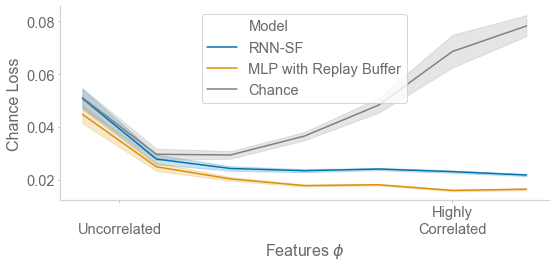

In [9]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(
    x='Sigma', y='Final Loss', hue='Model',
    ax = ax, data=df[(df['Gamma']==0.75)],
    hue_order=hue_order
    )
sns.lineplot(
    x='Sigma', y='Chance Loss',
    ax = ax, data=df[(df['Gamma']==0.75) & (df['Model']=='RNN-SF')],
    color='Gray', label='Chance'
    )
plt.xticks([0.5, np.unique(sigmas).size-2], ['\nUncorrelated', 'Highly\nCorrelated'])
plt.xlabel('Features $\phi$')
plt.tight_layout()
plt.savefig('4a_corrlineplot.png', dpi=300)

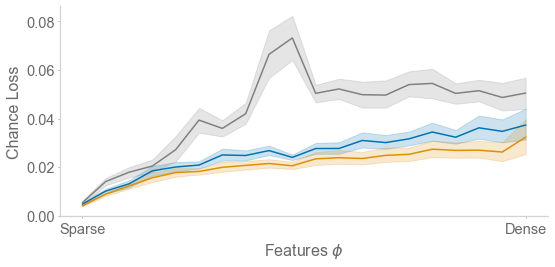

In [10]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(
    x='Sparsity', y='Final Loss', hue='Model',
    ax = ax, data=df[df['Gamma']==0.75],
    hue_order=hue_order, legend=None
    )
sns.lineplot(
    x='Sparsity', y='Chance Loss',
    ax = ax, data=df[(df['Gamma']==0.75) & (df['Model']=='RNN-SF')],
    color='Gray', label='Chance', legend=None
    )
xtick1 = df['Sparsity'].min()
xtick2 = df['Sparsity'].max()
plt.xticks([xtick1, xtick2], ['Sparse', 'Dense'])
plt.xlabel('Features $\phi$')
plt.tight_layout()
plt.savefig('4a_sparselineplot.png', dpi=300)

# Make 2D plots

In [11]:
np.unique(models)

array(['Linear', 'MLP with Replay Buffer', 'RNN-Oja', 'RNN-SF'],
      dtype='<U22')

In [12]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

In [13]:
def get_edge_nans(im):
    """ im is processed row-by-row (e.g., sigma by sparsity) """
    
    mask = np.zeros(im.shape).astype(bool)
    nrows, ncols = im.shape
    for i in range(nrows):
        j = 0
        while np.isnan(im[i,j]) and (j < ncols):
            mask[i,j] = True
            j += 1
    return mask

In [14]:
plt.rcParams.update({'hatch.color': 'darkgray'})

In [15]:
def make_gradients(
    xs, ys, zs, models, cmap="Reds",
    plottype='RNN-SF', chance_relative=False, chance_zs=None,
    title=None, xlabel=None, ylabel=None,
    figname=None, figsize=[6.4, 4.8],
    interpolate=False, smooth=False, contours=None,
    leave_edge_nans=True, xlim=None
    ):
    
    # Collect data into a meshgrid
    xs = xs.astype(float)
    ys = ys.astype(float)
    zs = zs.astype(float)
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    dxs = np.around(x_list[1:] - x_list[:-1], decimals=2)
    dys = np.around(y_list[1:] - y_list[:-1], decimals=2)
    if np.unique(dxs).size > 1 or np.unique(dys).size > 1:
        if smooth:
            print("Warning: Smoothing with inconsistent dx/dy")
    x_list = np.concatenate((x_list, [x_list[-1]+dxs[-1]]))
    y_list = np.concatenate((y_list, [y_list[-1]+dys[-1]]))
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            ij_idx = np.logical_and(
                np.logical_and(xs==x[i,j], ys==y[i,j]),
                models==plottype
                )
            _val = np.nanmean(zs[ij_idx])
            if chance_relative:
                _chance_val = np.nanmean(chance_zs[ij_idx])
                val = _chance_val/_val
            else:
                val = _val
            z[i,j] = val
    cmap = plt.get_cmap(cmap)
    cmap.set_bad('yellow')
    
    # Plot raw grid values
    fig, ax = plt.subplots()
    im = ax.pcolormesh(
        x, y, z, cmap=cmap
        )
    fig.colorbar(im, ax=ax)
    plt.show()
    
    # Remove padding used for pcolormesh plot
    x = x[:-1,:-1]
    y = y[:-1,:-1]
    z = z[:-1,:-1]
            
        
    # Mark NaNs
    nan_mask = np.isnan(z)
    edge_nan_mask = get_edge_nans(z)

    # Interpolate to fill in NaN cells
    if interpolate:
        if np.sum(nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X, data_y)

            interp_vals = reg.predict(
                np.vstack(
                [x[nan_mask].flatten(),
                 y[nan_mask].flatten()]).T
                )
            z[nan_mask] = interp_vals

    # Smooth over cells to denoise
    if smooth:
        from astropy.convolution import Gaussian2DKernel
        from astropy.convolution import convolve
        kernel = Gaussian2DKernel(x_stddev=1, y_stddev=1)
        z = convolve(z, kernel, preserve_nan=True)
    
    # Generate contour plots
    levels = MaxNLocator(nbins=20).tick_values(np.nanmin(z), np.nanmax(z))
    fig, ax = plt.subplots(figsize=figsize)

    cf = ax.contourf(x, y, z,
                     levels=levels, cmap=cmap
                     )
    if leave_edge_nans: # White out parts that were extrapolated
        nans = np.argwhere(edge_nan_mask)
        nan1 = nans[0]; nan2 = nans[-1]
        nan1x = x[nan1[0],nan1[1]]
        nan1y = y[nan1[0],nan1[1]]
        nan2x = x[nan2[0],nan2[1]]
        nan2y = y[nan2[0],nan2[1]]
        max_y = y.max()
        plt.fill(
            [nan1x, nan2x, nan1x],
            [nan1y, nan2y, max_y],
            color='white'
            )
    if xlim is not None: # Adjust x limits
        plt.xlim(xlim)
    if contours is not None: # Draw contours
        cntrs = plt.contourf(
            x, y, z, contours,
            hatches='//', alpha=0.01,
            colors='white'
            )
        plt.clabel(cntrs, inline=True, fontsize=12)
    fig.colorbar(cf, ax=ax)
    ax.set_title('contourf with levels')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300)
    plt.show()
    
    return x, y, z

In [16]:
_gamma = 0.75

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

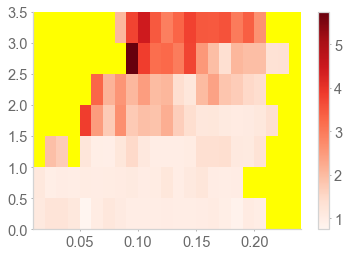

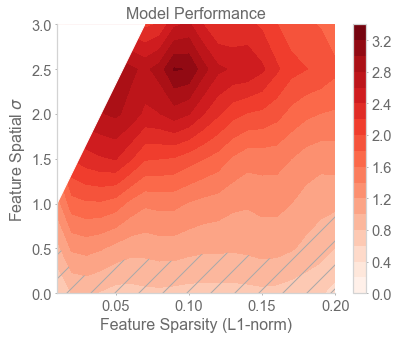

In [17]:
# RNN-SF
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_rnn_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='RNN-SF', chance_relative=True,
    chance_zs = _chance_losses, contours=[0.0, 1.0],
    xlim=[_sparsities.min(), 0.2]
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

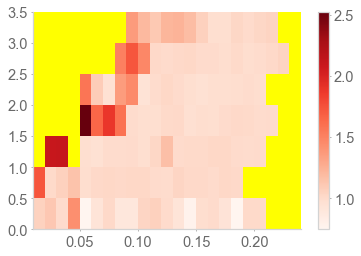

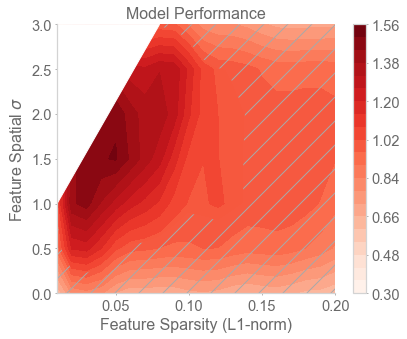

In [18]:
# RNN-Oja
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_rnn_oja_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='RNN-Oja', chance_relative=True,
    chance_zs = _chance_losses, contours=[0.0, 1.0],
    xlim=[_sparsities.min(), 0.2]
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

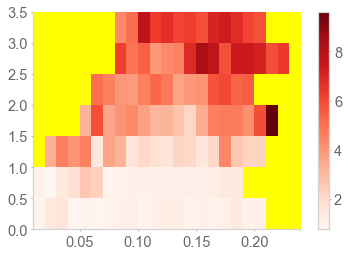

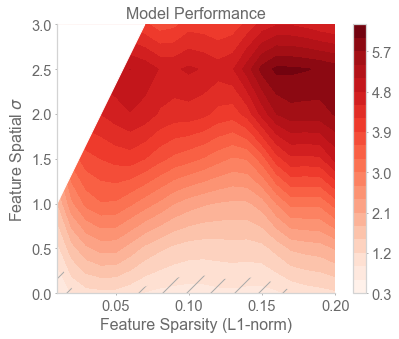

In [19]:
# Linear
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_linear_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='Linear', chance_relative=True,
    chance_zs = _chance_losses, contours=[0.0, 1.0],
    xlim=[_sparsities.min(), 0.2]
    )

## Loss as a function of gamma

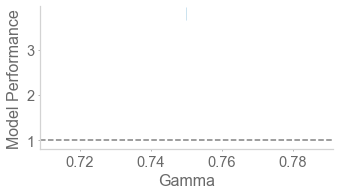

In [20]:
fig, ax = plt.subplots(figsize=(5,3))
sns.lineplot(
    x='Gamma', y='Fold Improvement from Chance',
    hue='Model',
    ax = ax,
    data=df[df['Model'] == 'Linear'],
    legend=None
    )
ax.set_ylim(0.8)
ax.axhline(1.0, color='gray', linestyle='--')
ax.set_ylabel('Model Performance')
plt.tight_layout()
plt.savefig('4a_gamma_perf.png', dpi=300)